Author: Abdulrahman Altahhan, 2025

The notebook uses a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard Python libraries (numpy, matplotlib etc.).
Please note that you will need permission from the author to use the code for research, commercially or otherwise.

# Worksheet 11- Tabular Methods: Planning and Learning

**Learning outcomes**
1. understand how to embed model learning withing an a reinforcement learning algorithms
2. understand mode-based RL approach
3. appreciate the boost in performance obtained due to infusing planning within the RL framework
4. appreciate that planning is usually possible for tabular RL while function approximation is still work in progress (mainly via replaying)

In this lesson, we cover a set of methods that use a blend of model-based and model-free to achieve planning and learning simultaneously. Planning involves using some model of the environment to predict the next action or reward of the environment and then use that to aid it in obtaining an estimate of the value function. We have already seen model-based algorithms in the early lesson. Can you remember what they are?... Dynamic programming it is. In this lesson, however, we take these concepts one step ahead, and we will develop a unified view of model-free (MC and TD etc.) and model-based (DP and other) algorithms. 

Model-based methods can be stochastic or deterministic this depending on the problem, but even if the environment itself is deterministic, we might want to come up with a stochastic model of it that will give us a distribution over all the states that represent the belief that an agent would be in state *sn* given that it was in state *s*, these are called distribution models. 

In fact, we had already seen such an approach when we dealt with the policy_evaluation() function in the DP lesson, where this function depends on the dynamics $p(s',r|s,a)$ to account for all of the different next state and rewards combinations to find an estimate. Distribution models are powerful because they allow us to sample from them at any point in time, but they are computationally expensive.

Another possibility is to use sampling. This might appear to contradict what we said earlier about model-free, which uses sampling to estimate the value function. The difference here is that we would use sampling to obtain what might sn be according to the model and then obtain an estimate of the value function. 

When the environment is deterministic, sampling can be used relatively efficiently to build the dynamics. In fact, we had already seen such an approach when we dealt with the dynamics() function in the DP lesson, where this function tries to estimate the dynamics of the environment by observing the next state and reward from a current state and action combination.

In all cases, the main advantage of planning is that we can plan ahead many steps *without actually taking action*, unlike non-planning algorithms such as TD. All we would be doing is to *assume* that the agent took action and then build on that. We can produce a whole imaginary episode using sampling, which is what we call a *simulated experience* which means it is an experience that the agent might take but is not real. With model-free sampling methods, we use an *actual experience* that the agent went through to estimate the value function. With distribution models, in theory, we can produce all possible episodes that the agent can take with their probabilities. Of course, that would mean accounting for many possibilities in both sampling and distribution models, and this is the main source of complexity in planning algorithms because they usually have a complexity of $O(n^2)$ where n is the number of states.

However, this difference between using a simulated or real experience is irrelevant from the update rules perspective. So, we can apply many of the covered methods in a simulated experience and a real experience. This is quite convenient since it will require less treatment and help us develop our unified view of planning and learning.
Note that in planning, we will not deal with prediction. We will cover control only because executing a plan naturally involves an advanced control scenario.

Finally, we should point out that due to the above complexity and assumptions, planning is usually confined to the tabular methods, and we will not see it when we move to function approximation which assumes that the state space can be infinite.

**Reading**:
The accompanying reading of this lesson is **chapter 8** of our text book available online [here](http://incompleteideas.net/book/RLbook2020.pdf). Please note that we explain the ideas of this topic from a practical perspective and not from a theoretical perspective which is already covered in the textbook.

In [1]:
%matplotlib inline

In [2]:
from rl.rl import *  # an RL base alg lib, value-based and policy-grad RL tabular algorithms
import bisect        # this will help to insert in a sorted Queue list

Let us start by covering a basic algorithm, that shows the basic idea of planning using sampling. 
Below we show the Random sample one-step Q-planning method.

## Dyna-Q: Integrating Model learning and Q Learning
In the DP lesson, we have built a dynamics() function used in the policy_iteration() and other functions. The dynamics() function is an example of model learning. We have used this function to provide a model for the DP algorithms, assuming it is already available. Hence, we started each of them with the model-learning step. This section will integrate the model learning with the direct RL learning we have seen in other lessons (like TD and MC). We use the real experience the agent is going through to improve both our model l of the environment (model learning) and our value-function estimation (direct RL learning).

In [3]:
class DynaQ(MDP()):
    def __init__(self, α=.1, m=10, **kw):
        super().__init__(**kw)
        self.α = α
        self.m = m          # how many steps to plan ahead
        self.store = False  # no need to store experience, the Model will give us what we need
        self.Model = np.zeros((self.env.nS, self.env.nA, 3)) # self.env.nR, self.env.nS))
        self.stop_early = self.πisoptimal # stop experiment when policy is optimal, need to set Tstar to take effect
        
    def init(self):
        self.nUpdates = 0 # number of updates to optimal solution
        super().init()

    
    #--------------------------------------🌖 online learning --------------------------------------
    def online(self, s, rn,sn, done, a,_):
        self.Q[s,a] += self.α*(rn + (1- done)*self.γ*self.Q[sn].max() - self.Q[s,a])
        self.Model[s,a] = [rn, sn, done]
        self.nUpdates +=1
        
        sa = np.argwhere(self.Model[:,:,1]!=np.array(None))
        for _ in range(self.m):    
            # get s,a that has been visited before and randomly select a pair of them
            
            ind = randint(sa.shape[0])
            s, a = sa[ind]
            
            rn,sn,done = self.Model[s,a]; sn=int(sn)        
            self.Q[s,a] += self.α*(rn + (1- done)*self.γ*self.Q[sn].max() - self.Q[s,a])
            self.nUpdates +=1
            
#             s = sn
#             rn,sn,done = self.Model[sn,self.Q[sn].max()]

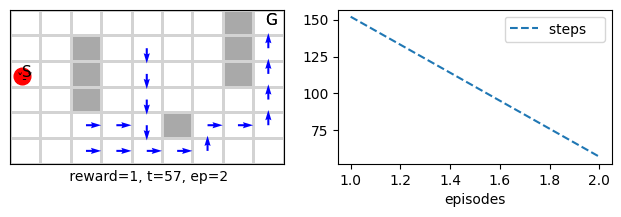

In [4]:
dynaQ = DynaQ(env=maze(), episodes=2, seed=10, m=50, **demoQ()).interact()

Let us see how many updates DynaQ had to do to achieve what it has achieved in the first 2 episodes!

In [5]:
dynaQ.nUpdates

10659

For comparison let us do the same for Q learning, ( DynaQ is equivalent to Q learning fro m=0). This agent will take a bit of time sine we are training for 2 episodes.

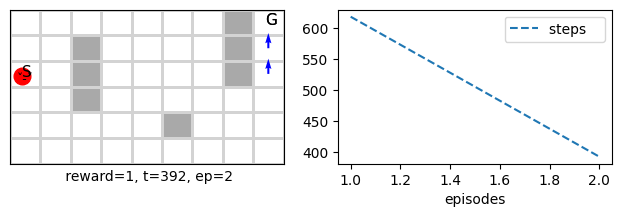

In [6]:
qlearn = DynaQ(env=maze(), episodes=2, seed=1, m=0, **demoQ()).interact()

In [7]:
qlearn.nUpdates

1011

As we can see the difference is huge between both, this difference shown on the performance. Let us study how the performance varies with n (the number of planning steps)

### The effect of planning steps on DynaQ

In [8]:
def mazePlanning(runs=30, algo=DynaQ, label='DynaQ', yticks=True):
    if yticks: plt.yticks([14, 200, 400, 600, 800])
    for m in [0, 5, 50]:
        DynaQ0 = Runs(algorithm=algo(env=maze(), α=.1, γ=.95, m=m, episodes=50), 
                      runs=runs, plotT=True).interact(label=label+' m = %d'%m)
fig_8_2 = mazePlanning

100%|██████████████████████████████████████████████████████████████████████████████████████████|30/30
100%|██████████████████████████████████████████████████████████████████████████████████████████|30/30
100%|██████████████████████████████████████████████████████████████████████████████████████████|30/30


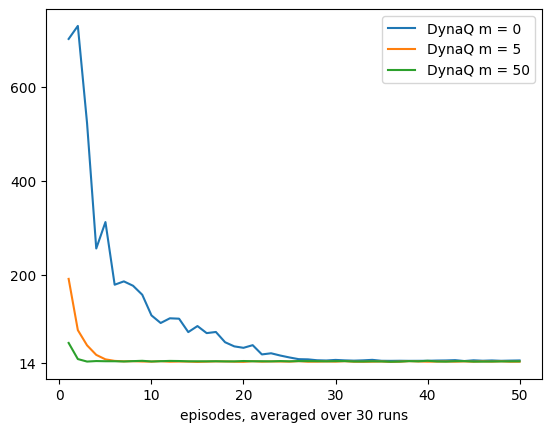

In [9]:
fig_8_2()

## Prioritized Sweeping
In DynaQ, the algorithm uniformly chooses n number of previously visited states and re-do their updates. This is ok when the environment is small. However, when the environment becomes big, the performance will dip, and the algorithm will need to do more updates per step to reach an optimal solution. This is where prioritising more important updates over less important ones optimises compute resource usage and achieves more in fewer steps. This is the idea of prioritized sweeping algorithms; it will sweep through different previous states' updates but prioritise those needing the most changes. It measures this priority by the absolute value of the TD error (yes, TD again!). The higher this error value is, the higher its corresponding priority is. It uses a queue to add states that need to update the most (as per their TD error) on the top of the queue. Then it will go through the queue one by one until its number of planning steps is done or until the queue is empty. The algorithm is shown below.

In [10]:
class Psweeping(MDP(MRP)):
    def __init__(self, α=.1, m=5, θ=1e-4, **kw):
        super().__init__(**kw)
        self.α = α
        self.m = m
        self.θ = θ
        
        self.store = False # no need to store experience, the Model will give us what we need
        self.Model = np.zeros((self.env.nS, self.env.nA, 3))
        self.stop_early = self.πisoptimal # stop experiment when policy is optimal, needs to set Tstar to take effect

        
    def init(self):
        self.PQueue = [] # collections.deque()# native list is more efficent than a linked list
        self.nUpdates = 0 # number of updates to optimal solution
        super().init()
    
    def insert(self, P,s,a): # P is the priority
        found_lowerP = False # found an entry with a lower priority
        for i, (P_old, s_old, _) in enumerate(self.PQueue[-2*self.m:]):
            if s==s_old:
                if P>=P_old: self.PQueue.pop(i)
                else:  found_lowerP = True
                break
        # insert the tuple in the right position according to P
        if not found_lowerP: bisect.insort_left(self.PQueue, (P,s,a))
   
    #--------------------------------------🌖 online learning --------------------------------------
    def online(self, s, rn,sn, done, a,_):

        P = abs(rn + (1- done)*self.γ*self.Q[sn].max() - self.Q[s,a])
        if P>=self.θ:  self.insert(P,s,a)
        self.Model[s,a] = [rn, sn, done]
        
        i=0
        while self.PQueue and i<=self.m:
            _,s,a = self.PQueue.pop()
            rn, sn, done = self.Model[s,a]; sn=int(sn)
            self.Q[s,a] += self.α*(rn + (1- done)*self.γ*self.Q[sn].max() - self.Q[s,a])
            self.nUpdates +=1
            i+=1
            
            # to guarantee equivelncy with Qlearning when θ=0, m=0
            if self.m==0: break 
            # go backward to previous states and actions sp, ap
            for sp,ap in np.argwhere(self.Model[:,:,1]==s):
                r,_,done= self.Model[sp,ap] #_==s
                P = abs(r + (1- done)*self.γ*self.Q[s].max() - self.Q[sp,ap])
                if P>=self.θ: self.insert(P,sp,ap)
            


Note that for the insert() function, we check first if state s is already in the queue, and if so, remove its entry if it has less priority than the new entry. Otherwise, do not add anything. 

PQueue is an ascending sorted queue according to P, not to s, and hence we cannot do a binary search for s, so we had to reside to linear search we tried to cut the search time by limiting the queue scope to 2n from the end of the queue.

Let us ensure that Qlearning and prioritized sweeping are almost identical for θ=0 and m=0.

100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10
100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10


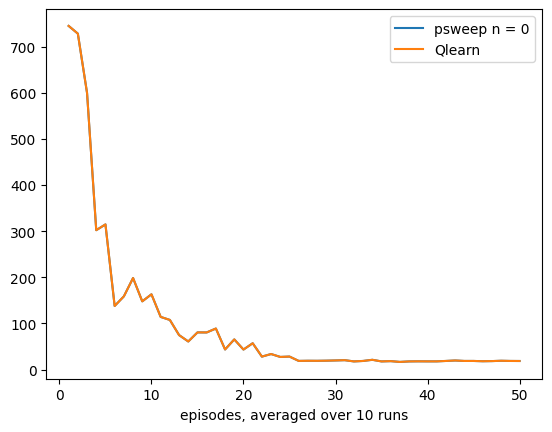

In [11]:
psweep0 = Runs(algorithm=Psweeping(env=maze(), α=.1, γ=.95, m=0, θ=0, episodes=50),runs=10, plotT=True).interact(label='psweep n = %d'%0)
qlearn = Runs(algorithm=Qlearn(env=maze(), α=.1, γ=.95, episodes=50),runs=10, plotT=True).interact(label='Qlearn')

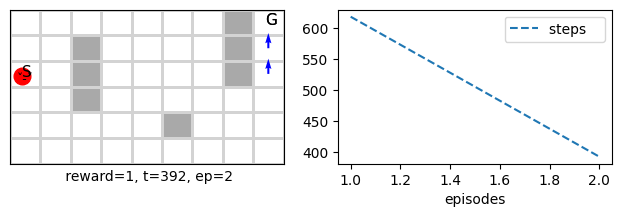

In [12]:
psweeping = Psweeping(env=maze(), episodes=2, seed=1, m=0, **demoQ()).interact()

In [13]:
psweeping.nUpdates

3

Note how prioritised sweeping done only 3 updates and compare this to DynaQ. 
Ok so now let us test with m=50

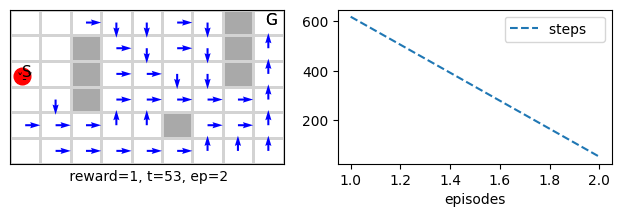

In [14]:
psweeping = Psweeping(env=maze(), episodes=2, seed=1, m=50, **demoQ()).interact()

In [15]:
psweeping.nUpdates

2754

Compare the above 5k number of updates for prioritised sweeping with the 32k number of update for DynaQ for the same number of planning states m=50. The difference is huge.

### The effect of planning steps on Prioritised Sweeping
Ok let us conduct the same experiment as before and test to see how the performance changes with n.

100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10
100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10
100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10


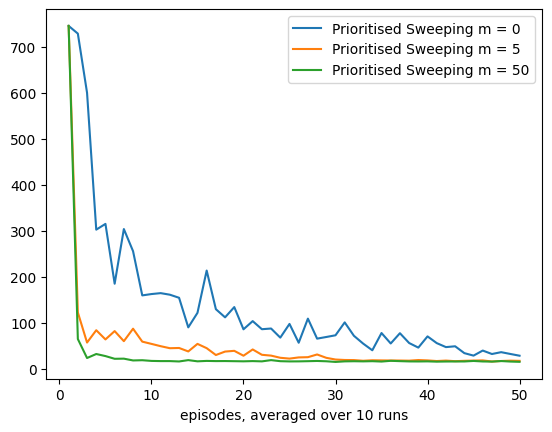

In [16]:
mazePlanning(runs=10, algo=Psweeping, label='Prioritised Sweeping', yticks=False)

## Prioritized sweeping on different maze sizes

In [17]:
def maze(rows=6, cols=9, **kw):
    return Grid(gridsize=[rows,cols], s0=int((rows)/2)*cols, goals=[rows*cols-1], style='maze', **kw)

In [18]:
class mazes:
    def __init__(self, m=6, **kw):
        gridsizes = [(6, 9), (9 , 12), (12, 18), (16, 26), (24, 34), (32, 50), (39, 81), (60, 104)][:m]
        self.env = []
        for rows,cols in gridsizes:
            self.env.append(maze(rows,cols, **kw))
    
    def __getitem__(self, i): return self.env[i]
    
    def sizes(self):
        sizes = [0]
        for mz in  self.env: sizes.append(mz.nS_available())
        return sizes

print(mazes().sizes())

[0, 47, 92, 188, 372, 748, 1500]


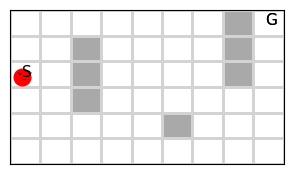

In [19]:
mazes()[0].render()

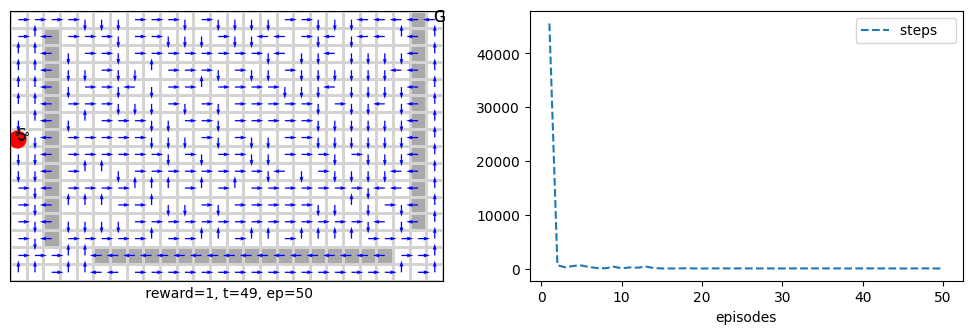

In [20]:
psweeping = Psweeping(env=mazes(figsize=[19,3.5])[3], α=.5, episodes=50, seed=1, m=5, **demoQ()).interact()

Let us examine the number of steps required by prioritised sweeping and compare it to the number of updates

In [21]:
psweeping.t

48

In [22]:
psweeping.nUpdates

36288

CPU times: user 43.1 s, sys: 7.77 s, total: 50.9 s
Wall time: 25.7 s


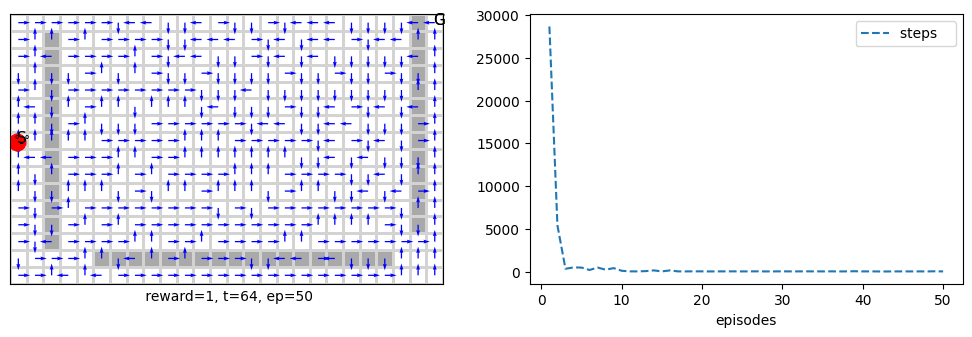

In [23]:
%time dynaQ = DynaQ(env=mazes(figsize=[19,3.5])[3], α=.5, episodes=50, seed=1, \
                    m=5, animate=True, **demoQ()).interact()

In [24]:
dynaQ.t

63

In [25]:
dynaQ.nUpdates

240648

As we can see there is a big difference between the number of updates for each algorithms.

After experimenting with the different mazes environment we can roughly come up with a reasonably flexible optimal number of steps for each environment which we stored in Tstar and is used in the below function.

## Runs and Comparison for Planning Algorithms
We need to write some new functions to perform several runs and comparisons while allowing the algorithm to stop before finishing all the episodes.
The reason we cannot use our original Runs class is due to allowing for stopping before finishing all the episodes. We show this simple function below.

In [26]:
def PlanningRuns(algorithm, runs=1, envs=mazes(), Tstar = [17,23,38,55,75,110,300]):
    nUpdates = np.ones((runs,len(envs.sizes())))*10
    for run in range(runs):
        for i, env in enumerate(envs):
            nUpdates[run,i+1] = algorithm(env=env, α=.5, episodes=60, m=5, Tstar=Tstar[i], seed=(i+1)*(run+10)).interact().nUpdates
    return nUpdates

In [27]:
class PlanningCompare:
    
    def __init__(self, algos=[DynaQ, Psweeping], runs=1, m=5):
        self.envs = mazes(m=m)
        self.algos = algos
        
        self.nUpdates = []
        for i, algo in enumerate(algos):
            print('\nMaze Planning with %s...........................'%algo.__name__)
            self.nUpdates.append(PlanningRuns(algorithm=algo, runs=runs, envs=self.envs ))
    
    def Plot(self):
        plt.yscale('log')
        sizes = self.envs.sizes()
        plt.xticks(sizes)
        for i, nUpdate in enumerate(self.nUpdates):
            plt.plot(sizes, self.nUpdates[i].mean(0), label=self.algos[i].__name__)

        plt.xlabel('Gridworld size (#states)')
        plt.ylabel('Updates until optimal solution')
        plt.legend()
        plt.show()

In [28]:
def example_8_4():
    PlanningCompare().Plot()


Maze Planning with DynaQ...........................
experience stopped at episode 5
experience stopped at episode 5
experience stopped at episode 11

Maze Planning with Psweeping...........................
experience stopped at episode 1
experience stopped at episode 4
experience stopped at episode 15
experience stopped at episode 32
experience stopped at episode 20


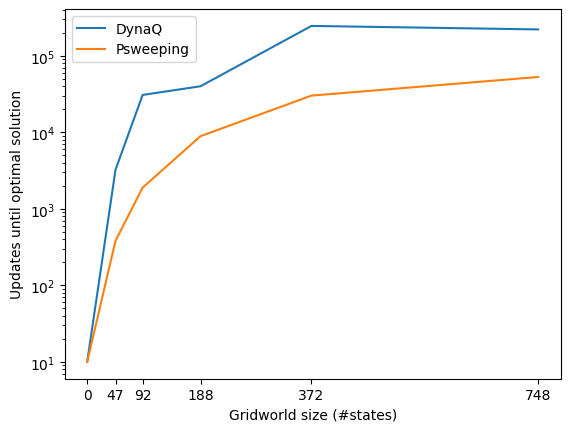

CPU times: user 28.8 s, sys: 646 ms, total: 29.5 s
Wall time: 29.3 s


In [29]:
%time example_8_4()

## Conclusion
This lesson covered two major planning algorithms, namely the Dyna-Q and the Prioritised Sweeping. These have variants, but what we covered are quite dominant algorithms in the RL planning landscape. We saw that Dyna-Q is quite good at finding a complete solution with the cost of a higher number of the uniformly selected past update. Prioritised Sweeping, on the other hand, is selective in its update and prioritises those expected to need the most attention due to the latest update, and they propagate backwards towards previously visited states. Prioritised sweeping is faster and more promising. However, we need to tune an extra hyperparameter of the threshold θ. In practice, a small value for θ seems to work fine, but we have to pay attention to the learning rate α as it also dictates the rate at which the update propagates backwards. If α is set to a small value, prioritised sweeping can suffer from a significant slowness in its performance.


## Your turn
1. consider what you would need to change in the prioritised sweeping in order to deal with a stochastic environment

[Back to TOC](IntroductionTOC.ipynb)